## Indonesia COVID 19 Forecast 2021 

#### Objective : 
To do forecast of Covid-19 in Indonesia 2021. As Delta varian hit the world, Indonesia become one of country which impacted alot of this varian and we would like to see future forecast of confirmed case.

#### Dataset source : 
Connecting to API https://api.covid19api.com/ so that we get the updated dataset from John Hopkins CSSE. 
Dataset will provide confirmed case from 1 January 2021 until 30 August 2021, with as much as 242 rows, have 10 columns (as can be seen in output code below) but in this research we only need the Confirmed case to conduct Time Series Analysis.

#### Model Used:
This research will conduct 6 various model to forecast the covid case: Time Series Modelling such as Single Exponential Smoothing, Double Exponential Smoothing, Triple Exponential Smoothing, ARIMA, SARIMA and since we can see the sequence plot of series much relate to polynomial series, then we also induced polynomial regression to see which model is better. In the end of this research we will see the result.

Note: If you do not want to see the code, you can skip below notebook and read the final passage.

In [5]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
#!pip install plotly
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import numpy as np
import datetime as dt
from datetime import timedelta
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score,silhouette_samples
from sklearn.linear_model import LinearRegression,Ridge,Lasso
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error,r2_score
import statsmodels.api as sm
from statsmodels.tsa.api import Holt,SimpleExpSmoothing,ExponentialSmoothing
from fbprophet import Prophet
from sklearn.preprocessing import PolynomialFeatures
from statsmodels.tsa.stattools import adfuller
from pmdarima import auto_arima
std=StandardScaler()

In [6]:
data = pd.read_json('indo covid 2021.json')
data.tail()

,Country,CountryCode,Province,City,CityCode,Lat,Lon,Cases,Status,Date
237,Indonesia,,,,,0,0,4043736,confirmed,2021-08-26 00:00:00+00:00
238,Indonesia,,,,,0,0,4056354,confirmed,2021-08-27 00:00:00+00:00
239,Indonesia,,,,,0,0,4066404,confirmed,2021-08-28 00:00:00+00:00
240,Indonesia,,,,,0,0,4073831,confirmed,2021-08-29 00:00:00+00:00
241,Indonesia,,,,,0,0,4089801,confirmed,2021-08-30 00:00:00+00:00


In [7]:
data.shape

(242, 10)

In [8]:
print("Size/Shape of the dataset: ",data.shape)
print("Checking for null values:\n",data.isnull().sum())
print("Checking Data-type of each column:\n",data.dtypes)

Size/Shape of the dataset:  (242, 10)
Checking for null values:
 Country        0
CountryCode    0
Province       0
City           0
CityCode       0
Lat            0
Lon            0
Cases          0
Status         0
Date           0
dtype: int64
Checking Data-type of each column:
 Country                     object
CountryCode                 object
Province                    object
City                        object
CityCode                    object
Lat                          int64
Lon                          int64
Cases                        int64
Status                      object
Date           datetime64[ns, UTC]
dtype: object


In [9]:
cols = ['Country', 'CountryCode', 'Province', 'City', 'CityCode', 'Lat', 'Lon','Status']
data.drop(cols, axis=1, inplace=True)
data = data.sort_values('Date')

In [10]:
case = data.set_index('Date')
case

,Cases
Date,
2021-01-01 00:00:00+00:00,751270
2021-01-02 00:00:00+00:00,758473
2021-01-03 00:00:00+00:00,765350
2021-01-04 00:00:00+00:00,772103
2021-01-05 00:00:00+00:00,779548
...,...
2021-08-26 00:00:00+00:00,4043736
2021-08-27 00:00:00+00:00,4056354
2021-08-28 00:00:00+00:00,4066404


In [11]:
case.isnull().sum()

Cases    0
dtype: int64

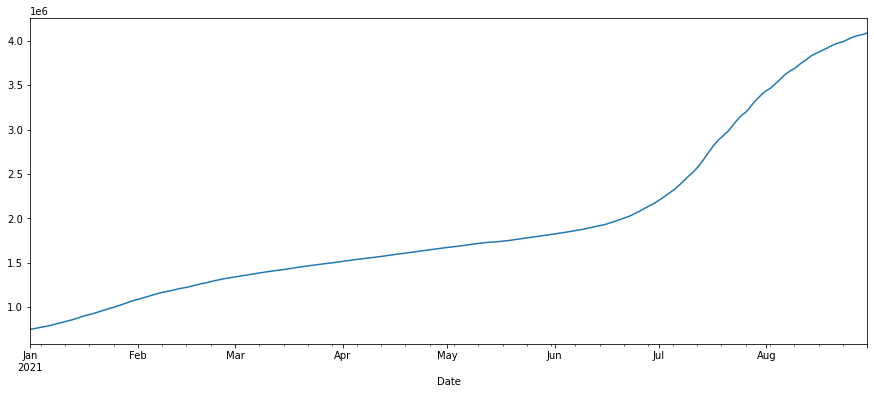

In [12]:
case['Cases'].plot(figsize=(15, 6))

In [13]:
#from pylab import rcParams
#rcParams['figure.figsize'] = 18, 8
#decomposition = sm.tsa.seasonal_decompose(case, model='additive')
#fig = decomposition.plot()
#plt.show()

#Have same output as below with simpler code

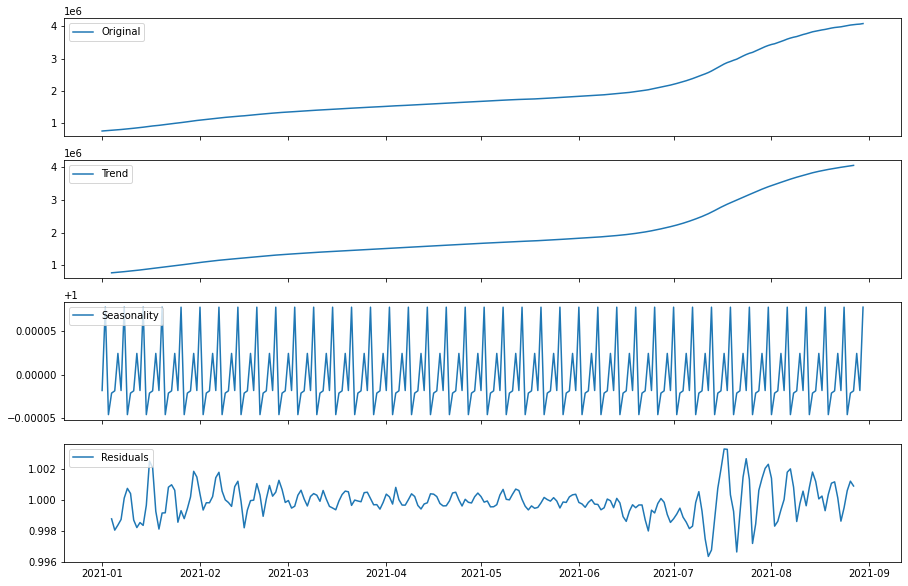

In [14]:
from statsmodels.tsa.seasonal import seasonal_decompose

ss_decomposition = seasonal_decompose(x=case, model='mul', period=6)
estimated_trend = ss_decomposition.trend
estimated_seasonal = ss_decomposition.seasonal
estimated_residual = ss_decomposition.resid

fig, axes = plt.subplots(4,1, sharex=True, sharey=False)
fig.set_figheight(10)
fig.set_figwidth(15)

axes[0].plot(case, label='Original')
axes[0].legend(loc='upper left');

axes[1].plot(estimated_trend, label='Trend')
axes[1].legend(loc='upper left');

axes[2].plot(estimated_seasonal, label='Seasonality')
axes[2].legend(loc='upper left');

axes[3].plot(estimated_residual, label='Residuals')
axes[3].legend(loc='upper left');

# Check whether series is stationary, have a trend, and seasonality

In [15]:
def run_sequence_plot(x, y, title, xlabel="time", ylabel="series"):
    plt.plot(x, y, 'k-')
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.grid(alpha=0.3);

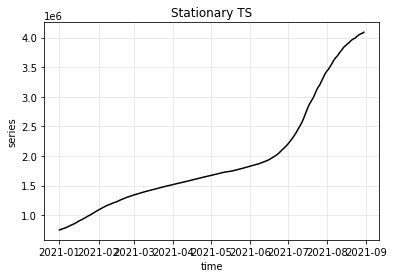

In [16]:
run_sequence_plot(data.Date, data.Cases, 
                  title="Stationary TS")

In [17]:
# define Dickey-Fuller Test (DFT) function
# Null is that unit root is present, rejection means likely stationary
import statsmodels.tsa.stattools as ts
def dftest(timeseries):
    dftest = ts.adfuller(timeseries,)
    dfoutput = pd.Series(dftest[0:4], 
                         index=['Test Statistic','p-value','Lags Used','Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)
    #Determing rolling statistics
    rolmean = timeseries.rolling(window=12).mean()
    rolstd = timeseries.rolling(window=12).std()

    #Plot rolling statistics:
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean and Standard Deviation')
    plt.grid()
    plt.show(block=False)

Test Statistic            1.548080
p-value                   0.997693
Lags Used                15.000000
Observations Used       226.000000
Critical Value (1%)      -3.459620
Critical Value (5%)      -2.874415
Critical Value (10%)     -2.573632
dtype: float64


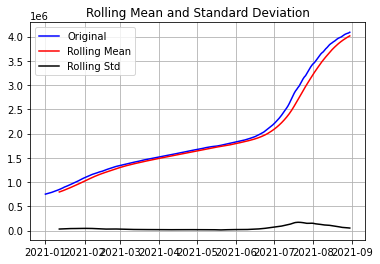

In [18]:
# run DFT on monthly
dftest(case.Cases)

# p-value fails to reject null hypothesis of non-stationary , thus data is non-stationary


There's a trend as we can see from rolling mean is not constant, and a little rolling standar deviation indicates non-constant variance. 

Now we'll be doing statistical test for trend seasonality using KPSS.
Null hypothesis for KPSS is opposite from ADF. If ADF null hypothesis is non-stationary, the KPSS null hypothesis is stationary. 

In [19]:
from statsmodels.tsa.stattools import adfuller, kpss

# ADF Test
result = adfuller(case.Cases.values, autolag='AIC')
print(f'ADF Statistic: {result[0]}')
print(f'p-value: {result[1]}')
for key, value in result[4].items():
    print('Critial Values:')
    print(f'   {key}, {value}')

# KPSS Test
result = kpss(case.Cases.values, regression='c')
print('\nKPSS Statistic: %f' % result[0])
print('p-value: %f' % result[1])
for key, value in result[3].items():
    print('Critial Values:')
    print(f'   {key}, {value}')

ADF Statistic: 1.54807952640862
p-value: 0.9976931399520121
Critial Values:
   1%, -3.4596204846395824
Critial Values:
   5%, -2.8744153028455948
Critial Values:
   10%, -2.5736320761218576

KPSS Statistic: 1.383305
p-value: 0.010000
Critial Values:
   10%, 0.347
Critial Values:
   5%, 0.463
Critial Values:
   2.5%, 0.574
Critial Values:
   1%, 0.739


As can we see here the confirmed case series is non-stationary and the trend seasonality indicating non-stationary also. 

Now we'll check autocorrelation of the series, statistically significance of autocorrelation (lies outside of the bluish area) means there is a correlation between datapoint and their lags, thus need to be transformed into stationary. Since linear regression requires independent set.

Daily data Autocorrelation Plots


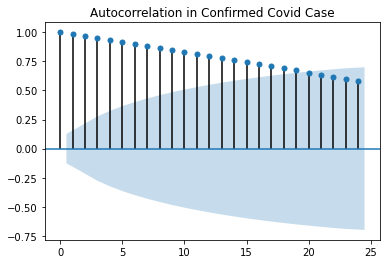

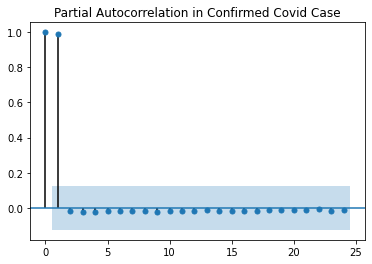

In [20]:
#Let's see the autocorrelation

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf, month_plot, quarter_plot

print('Daily data Autocorrelation Plots')
# Autocorrelation and Partial Autocorrelation Functions for Daily Data
#plot_acf(sales_new['Sales']['Furniture'])
acf_plot = plot_acf(data.Cases, lags=24, title='Autocorrelation in Confirmed Covid Case')
#plot_acf(sales_new['Sales']['Furniture'])
pacf_plot = plot_pacf(data.Cases, lags=24, title='Partial Autocorrelation in Confirmed Covid Case')
#plot_acf(sales_new['Sales']['Furniture'])

# Transforming Non-Stationary Series to Stationary Series

##### 1. Remove Trend and Seasonality using statsmodel

In [71]:
#Let's run the ADF test before transforming.

adf_b4, pvalue_b4, usedlag_, nobs_, critical_values_, icbest_ = adfuller(case.Cases)
print("ADF: ", adf_b4)
print("p-value: ", pvalue_b4)

ADF:  1.54807952640862
p-value:  0.9976931399520121


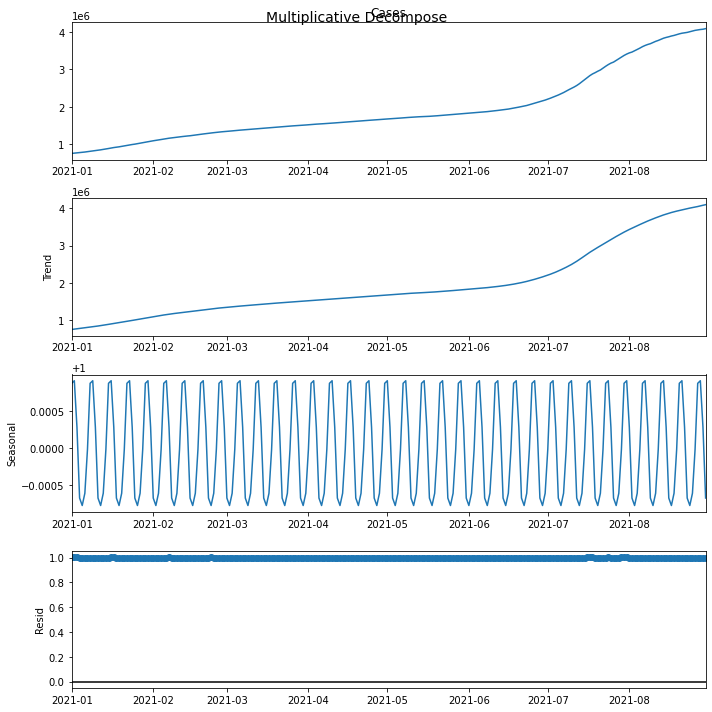

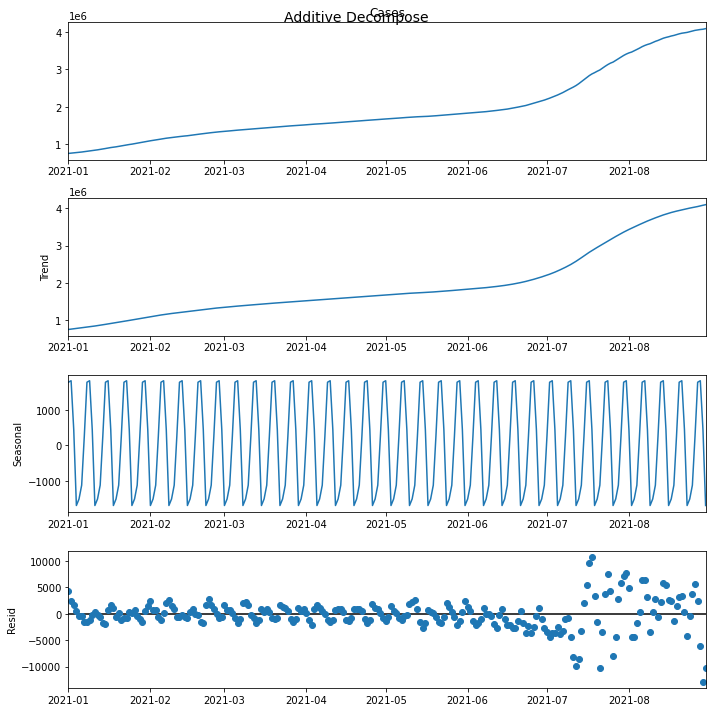

In [72]:
from statsmodels.tsa.seasonal import seasonal_decompose

# Multiplicative Decomposition 
result_mul = seasonal_decompose(case.Cases, model='multiplicative', extrapolate_trend='freq')

# Additive Decomposition
result_add = seasonal_decompose(case.Cases, model='additive', extrapolate_trend='freq')

# Plot
plt.rcParams.update({'figure.figsize': (10,10)})
result_mul.plot().suptitle('Multiplicative Decompose', fontsize=14)
result_add.plot().suptitle('Additive Decompose', fontsize=14)
plt.show()

The more random residual the better, hence we choose additive decomposition.

In [73]:
from statsmodels.tsa.seasonal import seasonal_decompose

#ss_decomposition = seasonal_decompose(x=case.Cases, model='additive', period=8)
est_trend = result_add.trend
est_seasonal = result_add.seasonal
est_residual = result_add.resid

In [74]:
print(est_residual)

Date
2021-01-01 00:00:00+00:00     4359.255267
2021-01-02 00:00:00+00:00     2441.624072
2021-01-03 00:00:00+00:00     1613.589961
2021-01-04 00:00:00+00:00      526.006288
2021-01-05 00:00:00+00:00     -365.751267
                                 ...     
2021-08-26 00:00:00+00:00     5701.147893
2021-08-27 00:00:00+00:00     2412.551186
2021-08-28 00:00:00+00:00    -6159.421846
2021-08-29 00:00:00+00:00   -12852.267182
2021-08-30 00:00:00+00:00   -10238.932488
Name: resid, Length: 242, dtype: float64


In [75]:
adf_after, pvalue_after, usedlag_, nobs_, critical_values_, icbest_ = adfuller(est_residual)
print("ADF: ", adf_after)
print("p-value: ", pvalue_after)

ADF:  -2.904819154724665
p-value:  0.04479045851425185


After decmposing series from its trend and seasonality, the series (residual) is now stationary. Later we can use this residual to do modelling. 

#### 2. Log Transformation 

In [76]:
X = case.Cases
X = np.log(X)
result = adfuller(X)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
for key, value in result[4].items():
	print('\t%s: %.3f' % (key, value))

ADF Statistic: 0.754393
p-value: 0.990863
	1%: -3.460
	5%: -2.874
	10%: -2.574


In [77]:
case['Log Cases'] = X

In [78]:
case

,Cases,Log Cases,Diff1,Diff2,Diff10
Date,,,,,
2021-01-01 00:00:00+00:00,751270,13.529520,NaN,NaN,NaN
2021-01-02 00:00:00+00:00,758473,13.539062,7203.0,NaN,NaN
2021-01-03 00:00:00+00:00,765350,13.548089,6877.0,14080.0,NaN
2021-01-04 00:00:00+00:00,772103,13.556873,6753.0,13630.0,NaN
2021-01-05 00:00:00+00:00,779548,13.566470,7445.0,14198.0,NaN
...,...,...,...,...,...
2021-08-26 00:00:00+00:00,4043736,15.212680,16899.0,35570.0,171998.0
2021-08-27 00:00:00+00:00,4056354,15.215795,12618.0,29517.0,163875.0
2021-08-28 00:00:00+00:00,4066404,15.218270,10050.0,22668.0,158157.0


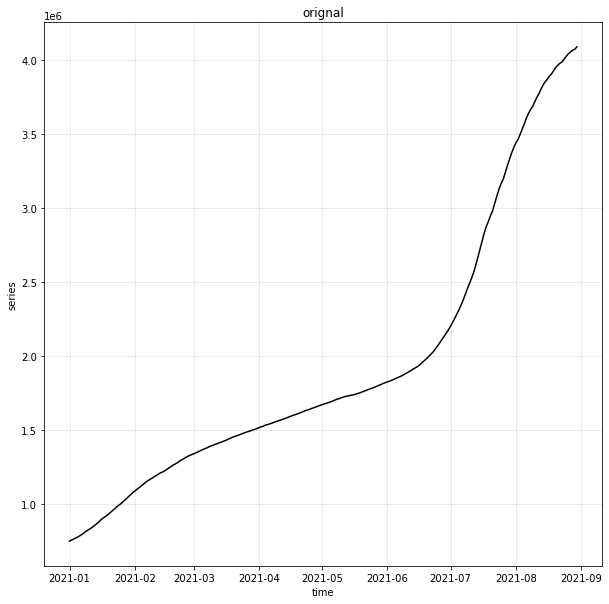

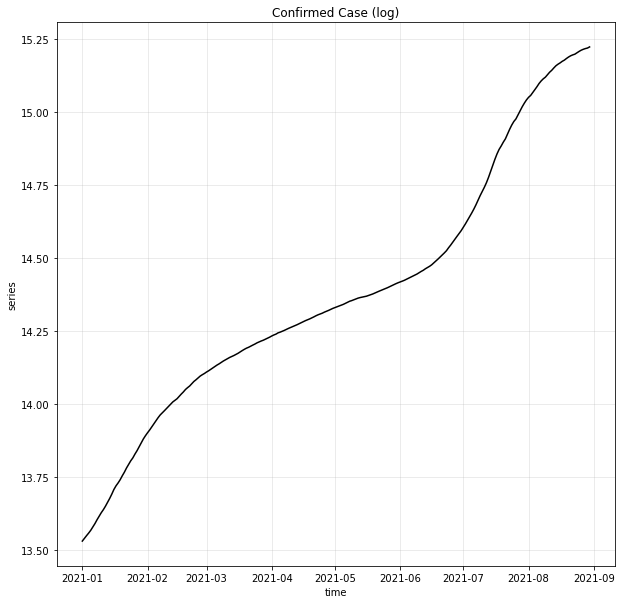

In [79]:
# run-sequence plots
run_sequence_plot(case.index, case.Cases,
                  title="orignal")
plt.show()

run_sequence_plot(case.index, case['Log Cases'],
                  title="Confirmed Case (log)")
plt.show()


Simply Log the series not be solution, the series still in non-stationary.

#### 3. Differencing

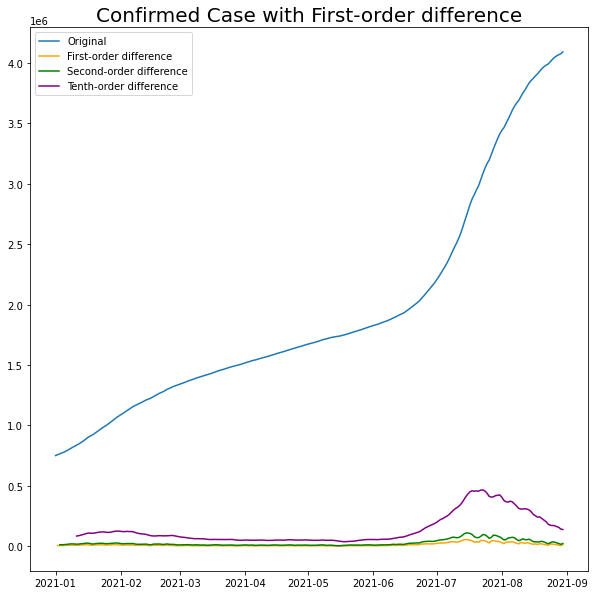

In [80]:
#Try various differencing order
case['Diff1'] = case['Cases'].diff(periods=1)
case['Diff2'] = case['Cases'].diff(periods=2)
case['Diff10'] = case['Cases'].diff(periods=10)

#case = case.dropna()

# Plot
plt.title('Confirmed Case with First-order difference', size=20)
plt.plot(case['Cases'], label='Original')
plt.plot(case['Diff1'], label='First-order difference', color='orange')

plt.plot(case['Diff2'], label='Second-order difference', color='green')

plt.plot(case['Diff10'], label='Tenth-order difference', color='purple')


plt.legend();

In [81]:
case.head()

,Cases,Log Cases,Diff1,Diff2,Diff10
Date,,,,,
2021-01-01 00:00:00+00:00,751270,13.529520,NaN,NaN,NaN
2021-01-02 00:00:00+00:00,758473,13.539062,7203.0,NaN,NaN
2021-01-03 00:00:00+00:00,765350,13.548089,6877.0,14080.0,NaN
2021-01-04 00:00:00+00:00,772103,13.556873,6753.0,13630.0,NaN
2021-01-05 00:00:00+00:00,779548,13.566470,7445.0,14198.0,NaN


In [82]:
adf_after, pvalue_after, usedlag_, nobs_, critical_values_, icbest_ = adfuller(case.Diff1[1:-1])
print("ADF: ", adf_after)
print("p-value: ", pvalue_after)

ADF:  -2.6183659154419745
p-value:  0.08926050464235391


In [83]:
adf_after, pvalue_after, usedlag_, nobs_, critical_values_, icbest_ = adfuller(case.Diff2[2:-2])
print("ADF: ", adf_after)
print("p-value: ", pvalue_after)

ADF:  -2.423017974658069
p-value:  0.13534486137462298


We can see from plot sequence above, by using order=1 slightly seem static (even there's a bit noise), but ADF tells it is still non-stationary. Here the better way is choosing differencing with order=1.

Here we can choose whether to use differencing=1 (but with weak stationary) or other way, we combine several methods such as differencing and removing trend/seasonality. 

In [84]:
#Check ADF for Residual of Differencing

ss_decomposition = seasonal_decompose(x=case.Diff1.dropna(), model='additive', period=8)
est_trend = ss_decomposition.trend
est_seasonal = ss_decomposition.seasonal
est_residual = ss_decomposition.resid

In [85]:
est_residual

Date
2021-01-02 00:00:00+00:00            NaN
2021-01-03 00:00:00+00:00            NaN
2021-01-04 00:00:00+00:00            NaN
2021-01-05 00:00:00+00:00            NaN
2021-01-06 00:00:00+00:00     493.621974
                                ...     
2021-08-26 00:00:00+00:00    3509.934474
2021-08-27 00:00:00+00:00            NaN
2021-08-28 00:00:00+00:00            NaN
2021-08-29 00:00:00+00:00            NaN
2021-08-30 00:00:00+00:00            NaN
Name: resid, Length: 241, dtype: float64

In [86]:
adf_after, pvalue_after, usedlag_, nobs_, critical_values_, icbest_ = adfuller(est_residual[4:-4])
print("ADF: ", adf_after)
print("p-value: ", pvalue_after)

ADF:  -5.38867237326091
p-value:  3.577789909955507e-06


Now we have stationary series!

# 1. ARIMA

In [114]:
model_train=case.Cases.iloc[:int(case.Diff1.shape[0]*0.95)]
valid=case.iloc[int(case.Cases.shape[0]*0.95):]
y_pred=valid.copy()
model_scores = []

In [115]:
model_train.head()

Date
2021-01-01 00:00:00+00:00    751270
2021-01-02 00:00:00+00:00    758473
2021-01-03 00:00:00+00:00    765350
2021-01-04 00:00:00+00:00    772103
2021-01-05 00:00:00+00:00    779548
Name: Cases, dtype: int64

In [116]:
model_arima= auto_arima(model_train,trace=True, error_action='ignore', 
                        start_p=0,start_q=0,max_p=2,max_q=2,
                        suppress_warnings=True,stepwise=False,seasonal=True)

model_arima.fit(model_train)

 ARIMA(0,2,0)(0,0,0)[1]             : AIC=4285.866, Time=0.15 sec
 ARIMA(0,2,1)(0,0,0)[1]             : AIC=4287.875, Time=0.05 sec
 ARIMA(0,2,2)(0,0,0)[1]             : AIC=4289.902, Time=0.08 sec
 ARIMA(1,2,0)(0,0,0)[1]             : AIC=4287.852, Time=0.04 sec
 ARIMA(1,2,1)(0,0,0)[1]             : AIC=4289.861, Time=0.14 sec
 ARIMA(1,2,2)(0,0,0)[1]             : AIC=4291.090, Time=0.52 sec
 ARIMA(2,2,0)(0,0,0)[1]             : AIC=4289.849, Time=0.15 sec
 ARIMA(2,2,1)(0,0,0)[1]             : AIC=4290.678, Time=0.12 sec
 ARIMA(2,2,2)(0,0,0)[1]             : AIC=4293.559, Time=0.11 sec

Best model:  ARIMA(0,2,0)(0,0,0)[1]          
Total fit time: 1.478 seconds


ARIMA(order=(0, 2, 0), scoring_args={}, seasonal_order=(0, 0, 0, 1),
      suppress_warnings=True, with_intercept=False)

In [117]:
prediction_arima=model_arima.predict(len(valid))
y_pred["ARIMA Model Prediction"]=prediction_arima

In [118]:
model_scores.append(np.sqrt(mean_squared_error(valid["Cases"],prediction_arima)))
print("Root Mean Square Error for ARIMA Model: ",np.sqrt(mean_squared_error(valid["Cases"],prediction_arima)))

Root Mean Square Error for ARIMA Model:  38161.04392419861


In [119]:
fig=go.Figure()
fig.add_trace(go.Scatter(x=model_train.index, y=model_train,
                    mode='lines+markers',name="Train Data for Confirmed Cases"))
fig.add_trace(go.Scatter(x=valid.index, y=valid.Cases,
                    mode='lines+markers',name="Validation Data for Confirmed Cases",))
fig.add_trace(go.Scatter(x=valid.index, y=y_pred["ARIMA Model Prediction"],
                    mode='lines+markers',name="Prediction for Confirmed Cases",))
fig.update_layout(title="Confirmed Cases ARIMA Model Prediction",
                 xaxis_title="Date",yaxis_title="Confirmed Cases",legend=dict(x=0,y=1,traceorder="normal"))
fig.show()

# 2. SARIMA MODEL

In [120]:
model_sarima= auto_arima(model_train,trace=True, error_action='ignore', 
                         start_p=0,start_q=0,max_p=2,max_q=2,m=8,
                   suppress_warnings=True,stepwise=True,seasonal=True)
model_sarima.fit(model_train)


Performing stepwise search to minimize aic
 ARIMA(0,2,0)(1,0,1)[8]             : AIC=4290.648, Time=0.11 sec
 ARIMA(0,2,0)(0,0,0)[8]             : AIC=4285.866, Time=0.02 sec
 ARIMA(1,2,0)(1,0,0)[8]             : AIC=4289.852, Time=0.08 sec
 ARIMA(0,2,1)(0,0,1)[8]             : AIC=4289.875, Time=0.12 sec
 ARIMA(0,2,0)(1,0,0)[8]             : AIC=4287.982, Time=0.10 sec
 ARIMA(0,2,0)(0,0,1)[8]             : AIC=4287.857, Time=0.21 sec
 ARIMA(1,2,0)(0,0,0)[8]             : AIC=4287.852, Time=0.02 sec
 ARIMA(0,2,1)(0,0,0)[8]             : AIC=4287.875, Time=0.03 sec
 ARIMA(1,2,1)(0,0,0)[8]             : AIC=4289.861, Time=0.07 sec
 ARIMA(0,2,0)(0,0,0)[8] intercept   : AIC=4287.770, Time=0.02 sec

Best model:  ARIMA(0,2,0)(0,0,0)[8]          
Total fit time: 0.807 seconds


ARIMA(order=(0, 2, 0), scoring_args={}, seasonal_order=(0, 0, 0, 8),
      suppress_warnings=True, with_intercept=False)

In [121]:
prediction_sarima=model_sarima.predict(len(valid))
y_pred["SARIMA Model Prediction"]=prediction_sarima

In [122]:
model_scores.append(np.sqrt(mean_squared_error(y_pred["Cases"],y_pred["SARIMA Model Prediction"])))
print("Root Mean Square Error for SARIMA Model: ",np.sqrt(mean_squared_error(y_pred["Cases"],y_pred["SARIMA Model Prediction"])))


Root Mean Square Error for SARIMA Model:  38161.04392419861


In [123]:
fig=go.Figure()
fig.add_trace(go.Scatter(x=model_train.index, y=case.Cases,
                    mode='lines+markers',name="Train Data for Confirmed Cases"))
fig.add_trace(go.Scatter(x=valid.index, y=valid.Cases,
                    mode='lines+markers',name="Validation Data for Confirmed Cases",))
fig.add_trace(go.Scatter(x=valid.index, y=y_pred["SARIMA Model Prediction"],
                    mode='lines+markers',name="Prediction for Confirmed Cases",))
fig.update_layout(title="Confirmed Cases SARIMA Model Prediction",
                 xaxis_title="Date",yaxis_title="Confirmed Cases",legend=dict(x=0,y=1,traceorder="normal"))
fig.show()

In [124]:
model_names=["ARIMA Model","SARIMA Model","Facebook's Prophet Model"]
model_summary=pd.DataFrame(zip(model_names,model_scores),columns=["Model Name","Root Mean Squared Error"]).sort_values(["Root Mean Squared Error"])
model_summary

,Model Name,Root Mean Squared Error
0,ARIMA Model,38161.043924
1,SARIMA Model,38161.043924


# 3. Polinomial Regression

In [125]:
poly = PolynomialFeatures(degree = 8)

In [126]:
train_poly=poly.fit_transform(np.array(model_train).reshape(-1,1))
valid_poly=poly.fit_transform(np.array(valid.Cases).reshape(-1,1))
y=model_train

In [127]:
linreg=LinearRegression(normalize=True)
linreg.fit(train_poly,y)

LinearRegression(normalize=True)

In [128]:
comp_data=poly.fit_transform(np.array(case["Cases"]).reshape(-1,1))
plt.figure(figsize=(11,6))
predictions_poly=linreg.predict(comp_data)

fig=go.Figure()
fig.add_trace(go.Scatter(x=case.index, y=case["Cases"],
                    mode='lines+markers',name="Train Data for Confirmed Cases"))
fig.add_trace(go.Scatter(x=case.index, y=predictions_poly,
                    mode='lines',name="Polynomial Regression Best Fit",
                    line=dict(color='black', dash='dot')))
fig.update_layout(title="Confirmed Cases Polynomial Regression Prediction",
                 xaxis_title="Date",yaxis_title="Confirmed Cases",
                 legend=dict(x=0,y=1,traceorder="normal"))
fig.show()


<Figure size 792x432 with 0 Axes>

In [129]:
prediction_poly=linreg.predict(valid_poly)
rmse_poly=np.sqrt(mean_squared_error(valid["Cases"],prediction_poly))
model_scores.append(rmse_poly)
print("Root Mean Squared Error for Polynomial Regression: ",rmse_poly)

model_names=["ARIMA Model","SARIMA Model","Polynomial Regression Model"]
model_summary=pd.DataFrame(zip(model_names,model_scores),columns=["Model Name","Root Mean Squared Error"]).sort_values(["Root Mean Squared Error"])
model_summary

Root Mean Squared Error for Polynomial Regression:  5.850421231304309e-09


,Model Name,Root Mean Squared Error
2,Polynomial Regression Model,5.850421e-09
0,ARIMA Model,3.816104e+04
1,SARIMA Model,3.816104e+04


## 4. Triple Exponential Smoothing Model

In [130]:
from statsmodels.tsa.api import ExponentialSmoothing

triple = ExponentialSmoothing(model_train,
                              trend="additive",
                              seasonal="additive",
                              seasonal_periods=3).fit(optimized=True)
prediction_triple = triple.forecast(len(valid))
y_pred['Triple Exponential'] = prediction_triple


model_scores.append(np.sqrt(mean_squared_error(y_pred["Cases"],y_pred["Triple Exponential"])))
print("Root Mean Square Error for Triple Exponential Model: ",np.sqrt(mean_squared_error(valid["Cases"],y_pred["Triple Exponential"])))


Root Mean Square Error for Triple Exponential Model:  31760.03710163942


In [131]:
model_names=["ARIMA Model","SARIMA Model","Polynomial Regression Model",'Triple Exponential']
model_summary=pd.DataFrame(zip(model_names,model_scores),columns=["Model Name","Root Mean Squared Error"]).sort_values(["Root Mean Squared Error"])
model_summary

,Model Name,Root Mean Squared Error
2,Polynomial Regression Model,5.850421e-09
3,Triple Exponential,3.176004e+04
0,ARIMA Model,3.816104e+04
1,SARIMA Model,3.816104e+04


In [132]:
fig=go.Figure()
fig.add_trace(go.Scatter(x=model_train.index, y=case.Cases,
                    mode='lines+markers',name="Train Data for Confirmed Cases"))
fig.add_trace(go.Scatter(x=valid.index, y=valid.Cases,
                    mode='lines+markers',name="Validation Data for Confirmed Cases",))
fig.add_trace(go.Scatter(x=valid.index, y=y_pred["Triple Exponential"],
                    mode='lines+markers',name="Prediction for Confirmed Cases",))
fig.update_layout(title="Confirmed Cases Triple Exponential Model Prediction",
                 xaxis_title="Date",yaxis_title="Confirmed Cases",legend=dict(x=0,y=1,traceorder="normal"))
fig.show()

## 5. Double Exponential (Holt)

In [133]:
from statsmodels.tsa.api import Holt

double = Holt(model_train).fit(optimized=True)
prediction_double = double.forecast(len(valid))
y_pred['Double Exponential'] = prediction_double

model_scores.append(np.sqrt(mean_squared_error(y_pred["Cases"],y_pred["Double Exponential"])))
print("Root Mean Square Error for Double Exponential Model: ",np.sqrt(mean_squared_error(valid["Cases"],y_pred["Double Exponential"])))


Root Mean Square Error for Double Exponential Model:  36591.75872332698


In [134]:
fig=go.Figure()
fig.add_trace(go.Scatter(x=model_train.index, y=model_train,
                    mode='lines+markers',name="Train Data for Confirmed Cases"))
fig.add_trace(go.Scatter(x=valid.index, y=valid.Cases,
                    mode='lines+markers',name="Validation Data for Confirmed Cases",))
fig.add_trace(go.Scatter(x=valid.index, y=y_pred["Double Exponential"],
                    mode='lines+markers',name="Prediction for Confirmed Cases",))
fig.update_layout(title="Confirmed Cases Double Exponential (Holt) Model Prediction",
                 xaxis_title="Date",yaxis_title="Confirmed Cases",legend=dict(x=0,y=1,traceorder="normal"))
fig.show()

## 6. Single Exponential

In [135]:
from statsmodels.tsa.api import SimpleExpSmoothing

single = SimpleExpSmoothing(model_train).fit(optimized=True)
prediction_single = single.forecast(len(valid))
y_pred['Single Exponential'] = prediction_single

model_scores.append(np.sqrt(mean_squared_error(y_pred["Cases"],y_pred["Single Exponential"])))
print("Root Mean Square Error for Single Exponential Model: ",np.sqrt(mean_squared_error(y_pred["Cases"],y_pred["Single Exponential"])))



Root Mean Square Error for Single Exponential Model:  127409.0364326547


In [136]:
fig=go.Figure()
fig.add_trace(go.Scatter(x=model_train.index, y=model_train,
                    mode='lines+markers',name="Train Data for Confirmed Cases"))
fig.add_trace(go.Scatter(x=valid.index, y=valid.Cases,
                    mode='lines+markers',name="Validation Data for Confirmed Cases",))
fig.add_trace(go.Scatter(x=valid.index, y=y_pred["Single Exponential"],
                    mode='lines+markers',name="Prediction for Confirmed Cases",))
fig.update_layout(title="Confirmed Cases Single Exponential Model Prediction",
                 xaxis_title="Date",yaxis_title="Confirmed Cases",legend=dict(x=0,y=1,traceorder="normal"))
fig.show()

In [137]:
model_names=["ARIMA Model","SARIMA Model","Polynomial Regression Model",'Triple Exponential','Double Exponential', 'Single Exponenential']
model_summary=pd.DataFrame(zip(model_names,model_scores),columns=["Model Name","Root Mean Squared Error"]).sort_values(["Root Mean Squared Error"])
model_summary

,Model Name,Root Mean Squared Error
2,Polynomial Regression Model,5.850421e-09
3,Triple Exponential,3.176004e+04
4,Double Exponential,3.659176e+04
0,ARIMA Model,3.816104e+04
1,SARIMA Model,3.816104e+04
5,Single Exponenential,1.274090e+05


### Finding Insight:

From data series of confirmed case since January to August 2021 in Indonesia, we see the data is highly non-stationary (see from Dicker Fueller pvalue score and sequence plot) hence we do several method to transform into stationary model such as removing trend/Seasonality using statsmodel, do Log Transformation, and Differencing. 

From p-value we got from removing trend and seasonality, the series successfully transformed into stationary model, while Log of series not work to transform (still be non-stationary). 
P-value of Differencing order=1 transformation indicating the series has weak-stationary. 
This is flaw of the dataset. 


As we can see from RMSE table of various model above, by conducting 6 various model we see Polynomial Regression model have a pretty small Root Mean Square Error of forecast (RMSE = 0.0000000058), and then Triple Exponential and Double Exponential Smoothing subsequently in order. As we can see from sequential plot, the series is much more similar to Polynomial.

Triple Exponential Smoothing become the second best since Triple Exponential Smoothing tackle well the trend and seasonality presented in the series data, while Double Exponential Plot captures only trend and does not handle the seasonality, as the series have trend and seasonality. 

From a glance, we can also see the Polynomial forecast really do a great job to forecast as the actual confirmed case presented. ARIMA, SARIMA does not do work well since the dataset flaws are lies into their weak seasonality, hence model seems hard to catch the good forecast. Single Exponential become worst, since the model captures no trend nor seasonality, opposite from the dataset. 

As for next work, we can elaborate the FB Prophet model, RNN and LSTM, to see whether these model would outperform the current model.
